# Episcanpy with OpenannotatePy

This tutorial focuses on epiScanpy’s analysis pipeline for scATAC-seq data, and application of OpenannotatePy to obtain reference data for scATAC-seq data dimensionality reduction, clustering

## Preprocessing and clustering scATAC PBMCs

In [76]:
!mkdir data

mkdir: data: File exists


In [2]:
!wget https://www.dropbox.com/s/cwlaaxl70t27tb2/data_tutorial_buenrostro.tar.gz?dl=0 -O data_tutorial_buenrostro.tar.gz

zsh:1: no matches found: https://www.dropbox.com/s/cwlaaxl70t27tb2/data_tutorial_buenrostro.tar.gz?dl=0


In [3]:
!cd data; tar -xzf data_tutorial_buenrostro.tar.gz

In [4]:
!mkdir write

## Load libraries

In [113]:
import scanpy as sc
import anndata as ad
import numpy as np
import pandas as pd
import episcanpy.api as epi

In [114]:
sc.settings.set_figure_params(dpi=80, color_map='gist_earth')

In [115]:
results_file = 'write/buenrostro_pbmc.h5ad'  # the file that will store the analysis results

## Load the data¶

Read in the count matrix into an AnnData object, which holds many slots for annotations and different representations of the data. It also comes with its own HDF5 file format: .h5ad.

In [116]:
adata = ad.read('data/data_tutorial_buenrostro/all_buenrostro_bulk_peaks.h5ad')
adata

AnnData object with n_obs × n_vars = 2034 × 491436
    obs: 'batch', 'cell_name'

In [117]:
adata

AnnData object with n_obs × n_vars = 2034 × 491436
    obs: 'batch', 'cell_name'

In [118]:
adata.X

<2034x491436 sparse matrix of type '<class 'numpy.float32'>'
	with 15206766 stored elements in Compressed Sparse Column format>

In [119]:
adata.obs

,batch,cell_name
BM1077-MPP-Frozen-160105-1.dedup.st.bam,0,BM1077-MPP-Frozen-160105-1
singles-20160726-scATAC-BM1137-GMP3high-HYC-88.dedup.st.bam,0,singles-20160726-scATAC-BM1137-GMP3high-HYC-88
singles-160808-scATAC-BM1137-GMP2mid-LS-65.dedup.st.bam,0,singles-160808-scATAC-BM1137-GMP2mid-LS-65
singles-BM0828-LMPP-frozen-151105-20.dedup.st.bam,0,singles-BM0828-LMPP-frozen-151105-20
singles-160819-BM1137-CMP-LS-95.dedup.st.bam,0,singles-160819-BM1137-CMP-LS-95
...,...,...
BM1077-LMPP-Frozen-160107-40.dedup.st.bam,1,BM1077-LMPP-Frozen-160107-40
BM1077-MPP-Frozen-160105-74.dedup.st.bam,1,BM1077-MPP-Frozen-160105-74
singles-BM1214-GMP-160421-9.dedup.st.bam,1,singles-BM1214-GMP-160421-9
singles-BM0828-LMPP-frozen-151105-62.dedup.st.bam,1,singles-BM0828-LMPP-frozen-151105-62


In [120]:
adata.obs['facs_label'] = ['MEP' if 'MEP' in line else line.split('.bam')[0].lstrip('singles-').split('BM')[-1].split('-')[1] for line in adata.obs['cell_name'].tolist()]
adata

AnnData object with n_obs × n_vars = 2034 × 491436
    obs: 'batch', 'cell_name', 'facs_label'

In [121]:
!head 'data/data_tutorial_buenrostro/metadata.tsv'

label	cell_type
BM1077-CLP-Frozen-160106-13	CLP
BM1077-CLP-Frozen-160106-14	CLP
BM1077-CLP-Frozen-160106-2	CLP
BM1077-CLP-Frozen-160106-21	CLP
BM1077-CLP-Frozen-160106-27	CLP
BM1077-CLP-Frozen-160106-3	CLP
BM1077-CLP-Frozen-160106-36	CLP
BM1077-CLP-Frozen-160106-42	CLP
BM1077-CLP-Frozen-160106-44	CLP


### Extract the FACs information from the file names

In [151]:
adata.obs['facs_label'] = ['MEP' if 'MEP' in line else line.split('.bam')[0].lstrip('singles-').split('BM')[-1].split('-')[1] for line in adata.obs['cell_name'].tolist()]
adata

AnnData object with n_obs × n_vars = 1722 × 122511
    obs: 'batch', 'cell_name', 'facs_label', 'label', 'cell_type', 'nb_features', 'log_nb_features'
    var: 'transcript_annotation', 'n_cells', 'commonness', 'prop_shared_cells', 'variability_score'
    uns: 'pca', 'neighbors', 'tsne', 'umap', 'cell_type_colors'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

### Load the additional metadata¶


In [122]:
adata.obs_names = [x.split('/')[-1].split('.dedup.st.bam')[0] for x in adata.obs_names.tolist()]
adata.obs_names

Index(['BM1077-MPP-Frozen-160105-1',
       'singles-20160726-scATAC-BM1137-GMP3high-HYC-88',
       'singles-160808-scATAC-BM1137-GMP2mid-LS-65',
       'singles-BM0828-LMPP-frozen-151105-20',
       'singles-160819-BM1137-CMP-LS-95', 'BM1077-MPP-Frozen-160105-36',
       'singles-20160726-scATAC-BM1214-CMP-LS-84',
       'BM1077-CMP-Frozen-160106-21', 'singles-BM0106-HSC-SIM-160219-36',
       'singles-BM1214-GMP-160421-60',
       ...
       'singles-160822-BM1137-CMP-LS-91',
       'singles-BM0828-CMP-frozen-151118-69',
       'singles-20160617-scATAC-BM1214-CMP-LS-40',
       'singles-BM0828-GMP-151027-2',
       'singles-20160726-scATAC-BM1214-CMP-LS-19',
       'BM1077-LMPP-Frozen-160107-40', 'BM1077-MPP-Frozen-160105-74',
       'singles-BM1214-GMP-160421-9', 'singles-BM0828-LMPP-frozen-151105-62',
       'singles-BM0828-MEP-160420-43'],
      dtype='object', length=2034)

In [123]:
epi.pp.load_metadata(adata,
                     'data/data_tutorial_buenrostro/metadata.tsv',
                     separator='\t')
adata

AnnData object with n_obs × n_vars = 2034 × 491436
    obs: 'batch', 'cell_name', 'facs_label', 'label', 'cell_type'

In [124]:
pd.crosstab(adata.obs['cell_type'], adata.obs['facs_label'])

facs_label,CLP,CMP,GMP,GMP1low,GMP2mid,GMP3high,HSC,LMPP,MCP,MEP,MPP,UNK,mono,pDC
cell_type,,,,,,,,,,,,,,
CLP,78,0,0,0,0,0,0,0,0,0,0,0,0,0
CMP,0,502,0,0,0,0,0,0,0,0,0,0,0,0
GMP,0,0,216,68,44,74,0,0,0,0,0,0,0,0
HSC,0,0,0,0,0,0,347,0,0,0,0,0,0,0
LMPP,0,0,0,0,0,0,0,160,0,0,0,0,0,0
MEP,0,0,0,0,0,0,0,0,0,138,0,0,0,0
MPP,0,0,0,0,0,0,0,0,0,0,142,0,0,0
UNK,0,0,0,0,0,0,0,0,0,0,0,60,0,0
mono,0,0,0,0,0,0,0,0,0,0,0,0,64,0


## Load gene/transcript annotation

Download annotation file (the data are aligned on hg19)

In [125]:
!wget ftp://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_human/release_19/gencode.v19.annotation.gtf.gz -O data/data_tutorial_buenrostro/gencode.v19.annotation.gtf.gz

--2022-06-15 18:34:42--  ftp://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_human/release_19/gencode.v19.annotation.gtf.gz
           => “data/data_tutorial_buenrostro/gencode.v19.annotation.gtf.gz”
正在解析主机 ftp.ebi.ac.uk (ftp.ebi.ac.uk)... 193.62.193.138
正在连接 ftp.ebi.ac.uk (ftp.ebi.ac.uk)|193.62.193.138|:21... 已连接。
正在以 anonymous 登录 ... 登录成功！
==> SYST ... 完成。   ==> PWD ... 完成。
==> TYPE I ... 完成。 ==> CWD (1) /pub/databases/gencode/Gencode_human/release_19 ... 完成。
==> SIZE gencode.v19.annotation.gtf.gz ... 37991892
==> PASV ... 完成。   ==> RETR gencode.v19.annotation.gtf.gz ... 完成。
长度：37991892 (36M) (非正式数据)

gencode.v19.annotat 100%[===================>]  36.23M   235KB/s  用时 2m 50s    

2022-06-15 18:37:35 (219 KB/s) - “data/data_tutorial_buenrostro/gencode.v19.annotation.gtf.gz” 已保存 [37991892]



In [126]:
!cd data/data_tutorial_buenrostro; gunzip gencode.v19.annotation.gtf

gunzip: gencode.v19.annotation.gtf: unknown suffix -- ignored


In [127]:
epi.tl.find_genes(adata,
           gtf_file='data/data_tutorial_buenrostro/gencode.v19.annotation.gtf',
           key_added='transcript_annotation',
           upstream=2000,
           feature_type='transcript',
           annotation='HAVANA',
           raw=False)

## Preprocessing

Check if the data matrix is binary - if not, binarize the data matrix¶

In [128]:
print(np.max(adata.X))

1.0


In [129]:
epi.pp.filter_cells(adata, min_features=1)
epi.pp.filter_features(adata, min_cells=1)

### Quality controls

In [130]:
adata.obs['log_nb_features'] = [np.log10(x) for x in adata.obs['nb_features']]
adata

AnnData object with n_obs × n_vars = 2034 × 467226
    obs: 'batch', 'cell_name', 'facs_label', 'label', 'cell_type', 'nb_features', 'log_nb_features'
    var: 'transcript_annotation', 'n_cells'

... storing 'facs_label' as categorical
... storing 'cell_type' as categorical
... storing 'transcript_annotation' as categorical


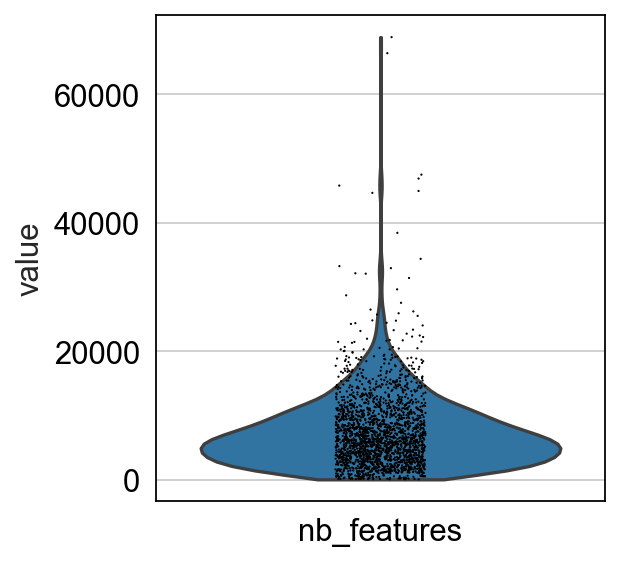

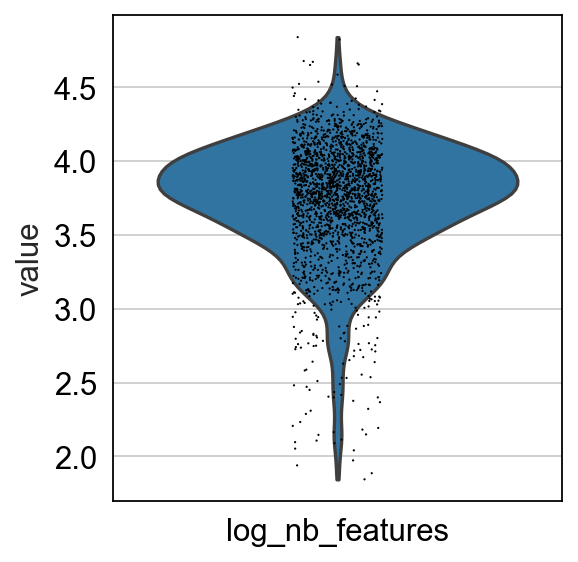

In [131]:
epi.pl.violin(adata, ['nb_features'])
epi.pl.violin(adata, ['log_nb_features'])

### Actually proceed to filter the cells and peaks based on the QC plots

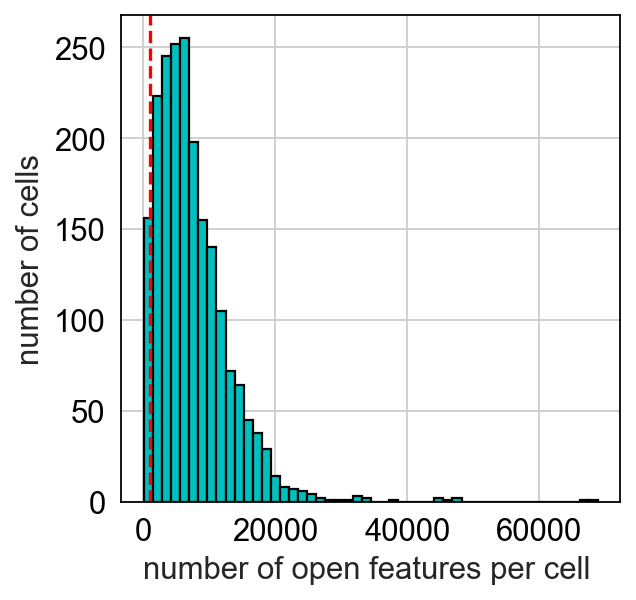

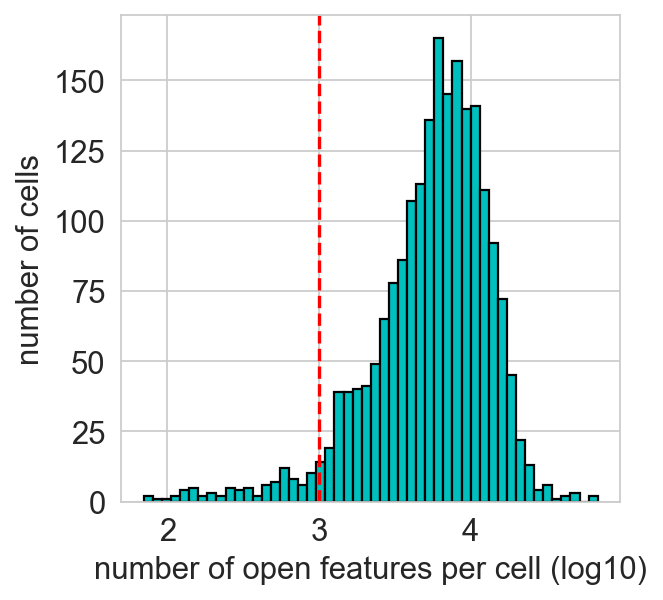

In [132]:
# set a minimum number of cells to keep 
min_features = 1000

epi.pp.coverage_cells(adata, binary=True, log=False, bins=50,
               threshold=min_features, save='Buenrostro_bulk_peaks_coverage_cells.png')
epi.pp.coverage_cells(adata, binary=True, log=10, bins=50,
               threshold=min_features, save='Buenrostro_bulk_peaks_coverage_cells_log10.png')

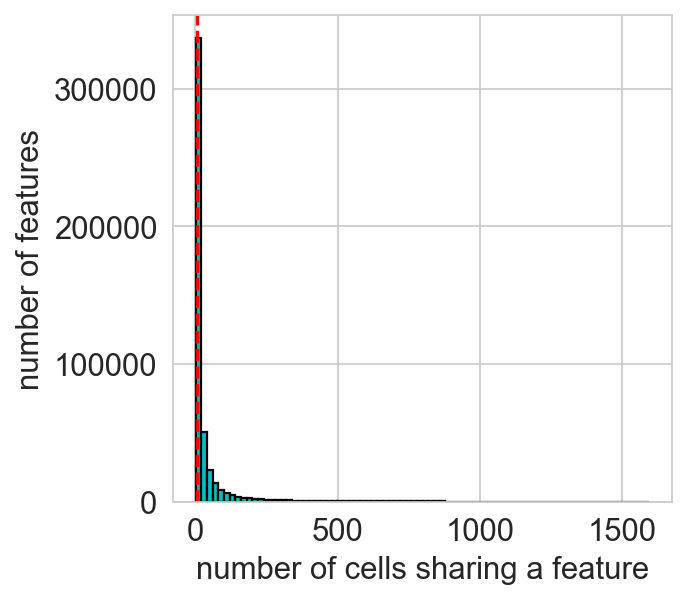

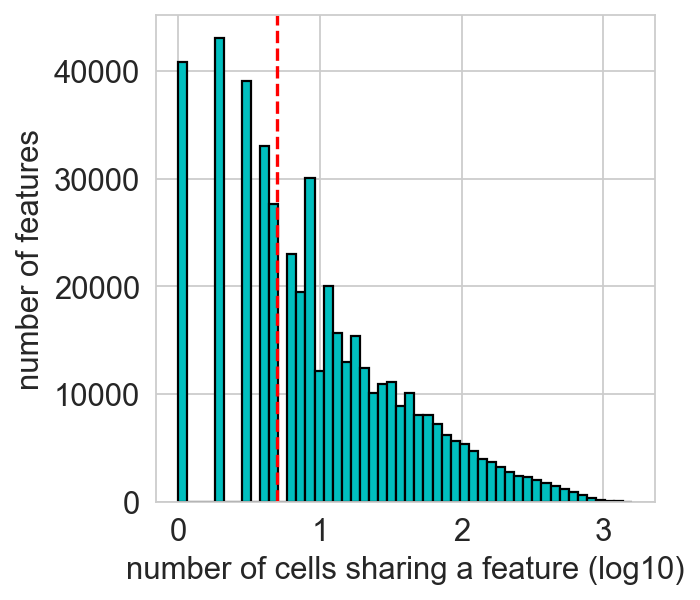

In [133]:
# minimum number of cells sharing a feature
min_cells = 5
epi.pp.coverage_features(adata, binary=True, log=False, 
                        threshold=min_cells, save='Buenrostro_bulk_peaks_coverage_peaks.png')
epi.pp.coverage_features(adata, binary=True, log=True, 
                        threshold=min_cells, save='Buenrostro_bulk_peaks_coverage_peaks_log10.png')

In [134]:
min_features = 1000
epi.pp.filter_cells(adata, min_features=min_features)
adata

AnnData object with n_obs × n_vars = 1945 × 467226
    obs: 'batch', 'cell_name', 'facs_label', 'label', 'cell_type', 'nb_features', 'log_nb_features'
    var: 'transcript_annotation', 'n_cells', 'commonness'

In [135]:
min_cells = 5
epi.pp.filter_features(adata, min_cells=min_cells)
adata

AnnData object with n_obs × n_vars = 1945 × 311035
    obs: 'batch', 'cell_name', 'facs_label', 'label', 'cell_type', 'nb_features', 'log_nb_features'
    var: 'transcript_annotation', 'n_cells', 'commonness'

###  Looking at the QC plots after filtering

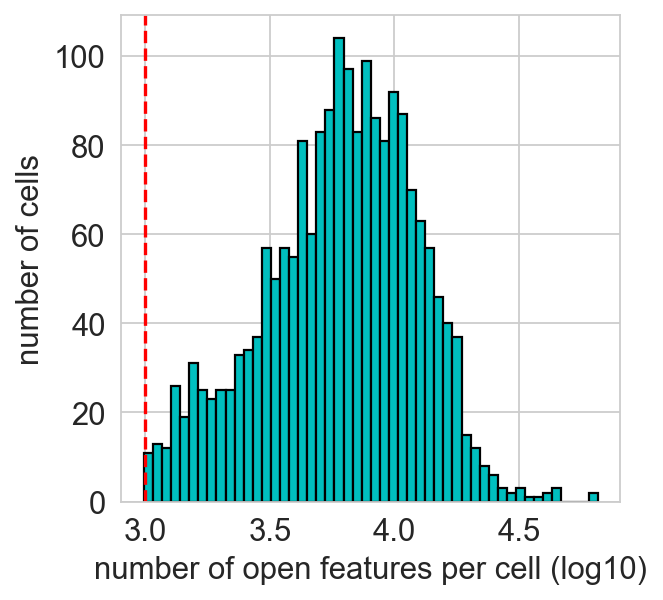

In [136]:
epi.pp.coverage_cells(adata, binary=True, log='log10', bins=50, threshold=min_features)

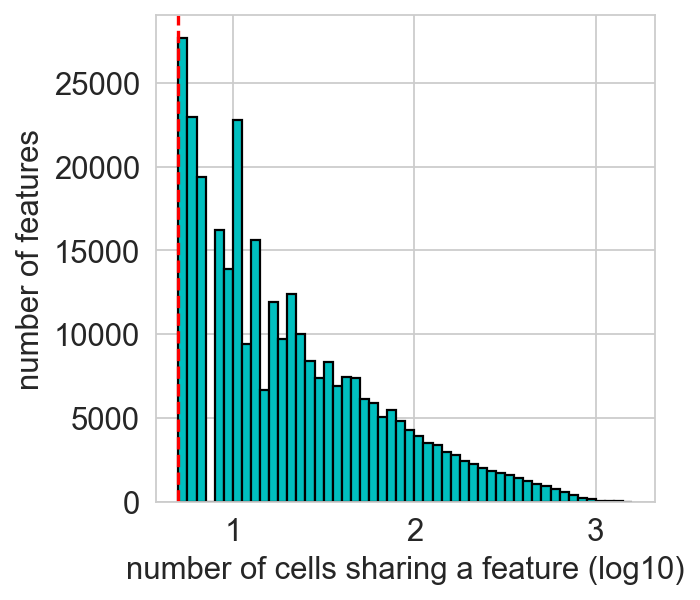

In [137]:
epi.pp.coverage_features(adata, binary=True, log='log10', bins=50, threshold=min_cells)

### Identifying the most variable features¶

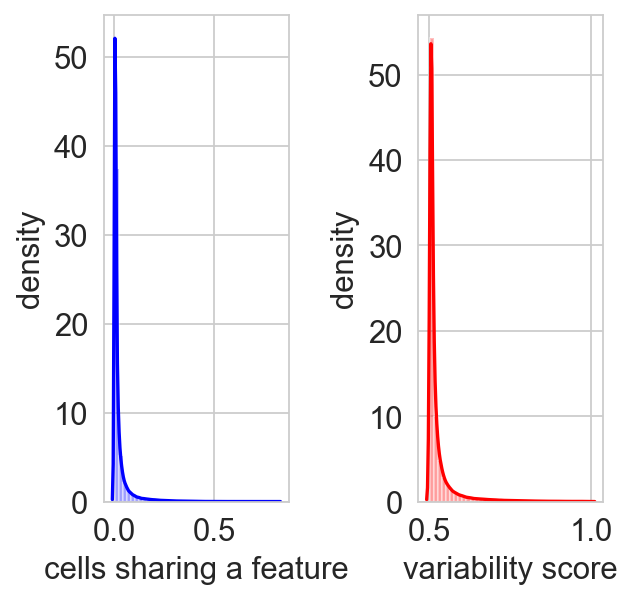

In [138]:
epi.pp.cal_var(adata)

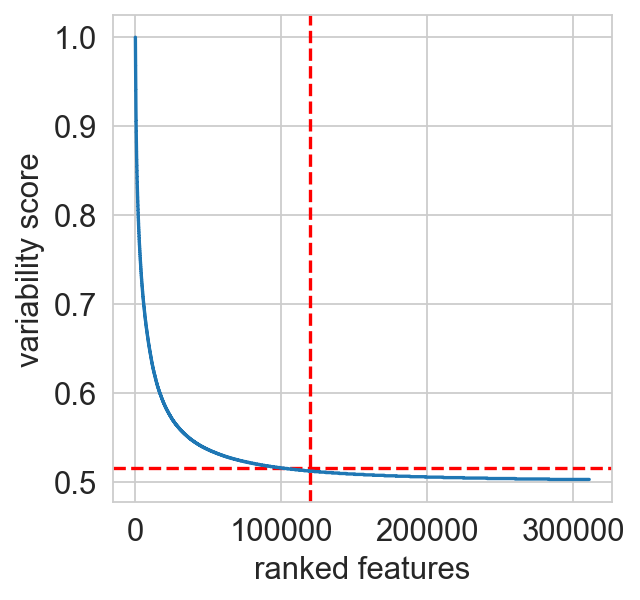

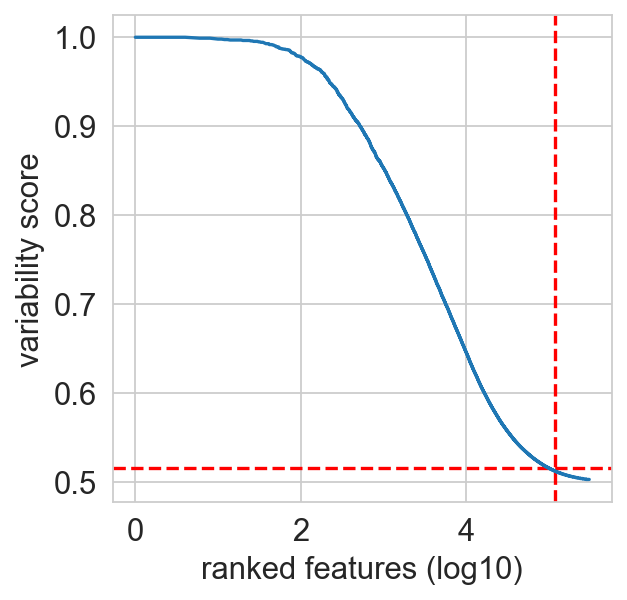

In [139]:
min_score_value = 0.515
nb_feature_selected = 120000
epi.pl.variability_features(adata,log=None,
                     min_score=min_score_value, nb_features=nb_feature_selected,
                     save='variability_features_plot_bonemarrow_peakmatrix.png')

epi.pl.variability_features(adata,log='log10',
                     min_score=min_score_value, nb_features=nb_feature_selected,
                     save='variability_features_plot_bonemarrow_peakmatrix_log10.png')

In [140]:
adata.raw = adata

In [141]:
adata = epi.pp.select_var_feature(adata,
                                  nb_features=nb_feature_selected,
                                  show=False,
                                  copy=True)

In [142]:
adata

View of AnnData object with n_obs × n_vars = 1945 × 122511
    obs: 'batch', 'cell_name', 'facs_label', 'label', 'cell_type', 'nb_features', 'log_nb_features'
    var: 'transcript_annotation', 'n_cells', 'commonness', 'prop_shared_cells', 'variability_score'

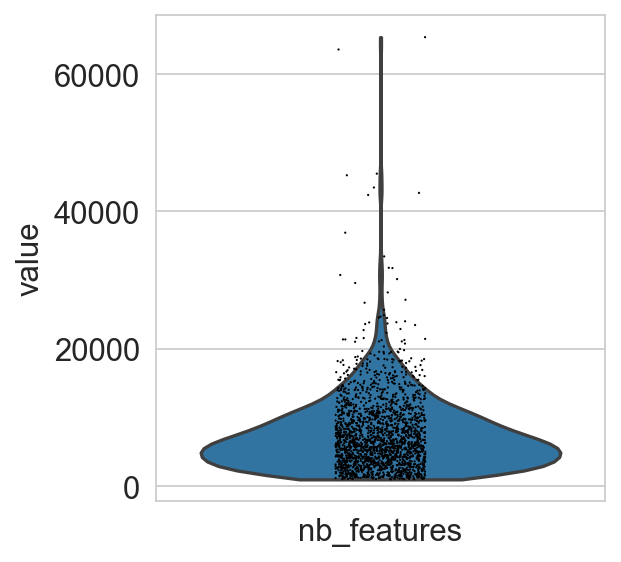

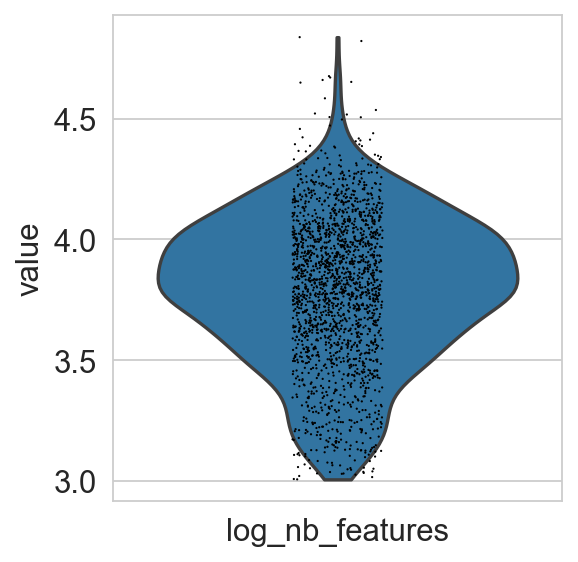

In [143]:
epi.pl.violin(adata, ['nb_features'])
epi.pl.violin(adata, ['log_nb_features'])

In [144]:
epi.pp.filter_cells(adata, min_features=2000)
epi.pp.filter_cells(adata, max_features=25000)

Trying to set attribute `.obs` of view, copying.


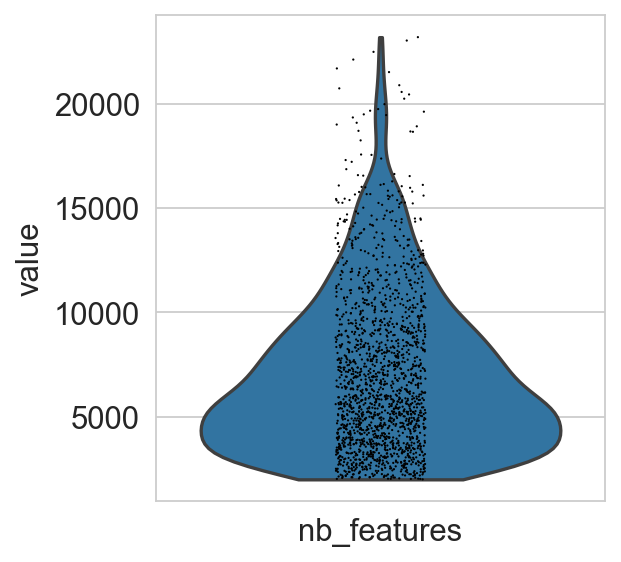

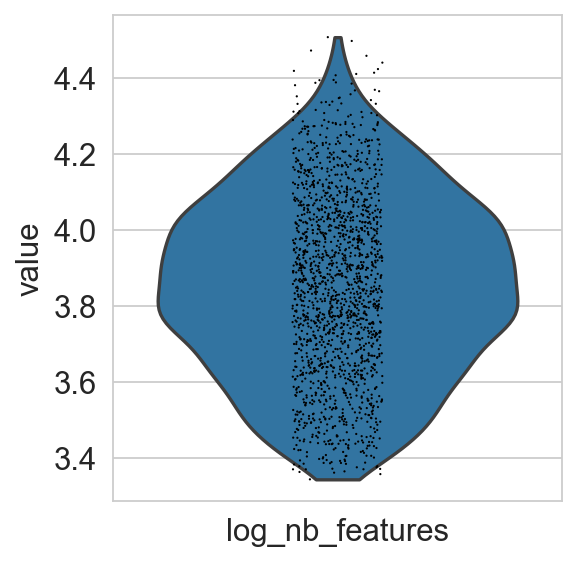

In [145]:
epi.pl.violin(adata, ['nb_features'])
epi.pl.violin(adata, ['log_nb_features'])

In [146]:
adata

AnnData object with n_obs × n_vars = 1722 × 122511
    obs: 'batch', 'cell_name', 'facs_label', 'label', 'cell_type', 'nb_features', 'log_nb_features'
    var: 'transcript_annotation', 'n_cells', 'commonness', 'prop_shared_cells', 'variability_score'

In [147]:
adata.obs['cell_name']

singles-20160726-scATAC-BM1137-GMP3high-HYC-88    singles-20160726-scATAC-BM1137-GMP3high-HYC-88
singles-160808-scATAC-BM1137-GMP2mid-LS-65            singles-160808-scATAC-BM1137-GMP2mid-LS-65
singles-160819-BM1137-CMP-LS-95                                  singles-160819-BM1137-CMP-LS-95
BM1077-MPP-Frozen-160105-36                                          BM1077-MPP-Frozen-160105-36
singles-20160726-scATAC-BM1214-CMP-LS-84                singles-20160726-scATAC-BM1214-CMP-LS-84
                                                                       ...                      
BM1077-LMPP-Frozen-160107-40                                        BM1077-LMPP-Frozen-160107-40
BM1077-MPP-Frozen-160105-74                                          BM1077-MPP-Frozen-160105-74
singles-BM1214-GMP-160421-9                                          singles-BM1214-GMP-160421-9
singles-BM0828-LMPP-frozen-151105-62                        singles-BM0828-LMPP-frozen-151105-62
singles-BM0828-MEP-160420-43  

In [148]:
adata_copy = adata

## Normalisation

#### Quick visualisation before normalisation

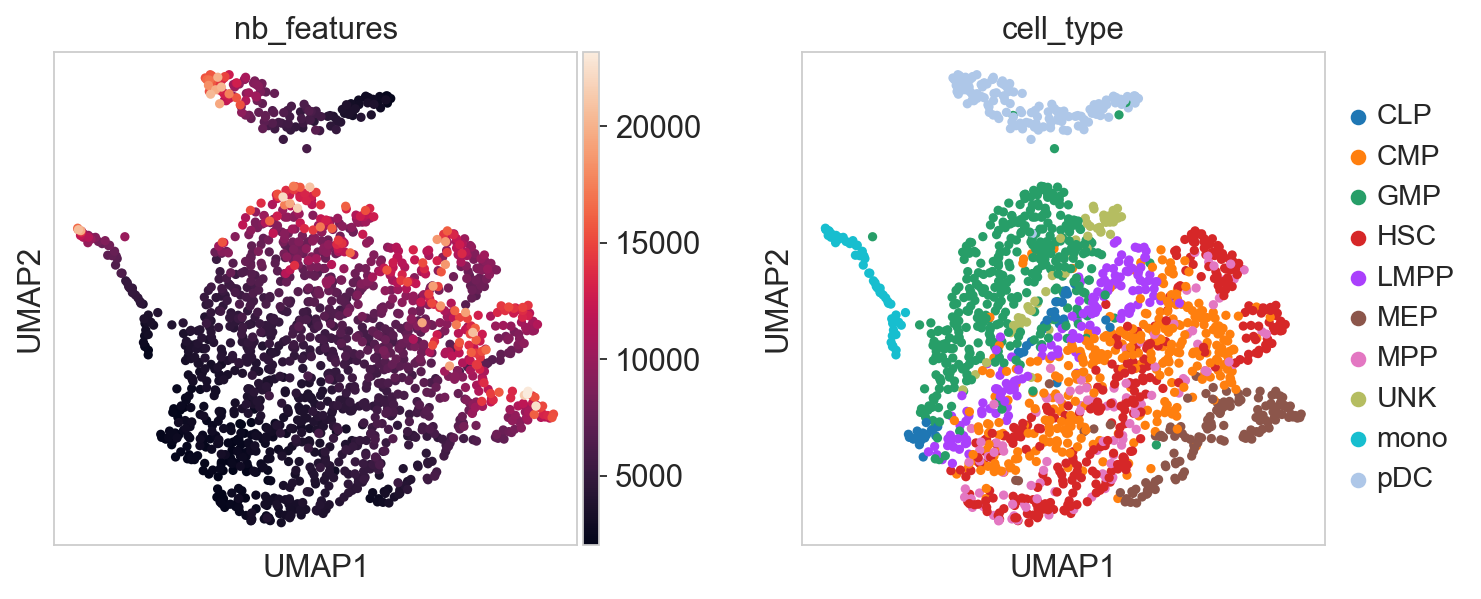

In [149]:
epi.pp.lazy(adata)
sc.pl.umap(adata, color=['nb_features', 'cell_type'], wspace=0.3)

## OpenAnnotatePy for reference data

### Extract genomic regions

In [150]:
regions = adata.var_names
regions = [i.split('_') for i in regions]
for region in regions:
    region.extend(['.','.','.'])

In [66]:
filename = 'episcanpy.bed'
with open (filename,'w') as file_object:
    for line in regions:
        file_object.write('\t'.join(line) + "\n")   

In [48]:
!pip install OpenAnnotatePy

     |████████████████████████████████| 62 kB 811 kB/s eta 0:00:01
  Attempting uninstall: requests
    Found existing installation: requests 2.24.0
    Uninstalling requests-2.24.0:
      Successfully uninstalled requests-2.24.0
ERROR: After October 2020 you may experience errors when installing or updating packages. This is because pip will change the way that it resolves dependency conflicts.

We recommend you use --use-feature=2020-resolver to test your packages with the new resolver before it becomes the default.

conda 4.12.0 requires ruamel_yaml_conda>=0.11.14, which is not installed.


### Load OpenAnnotatePy and submit annotation jobs

In [49]:
from OpenAnnotatePy import OpenAnnotateApi

In [50]:
oaa=OpenAnnotateApi.Annotate()

Use object.help() to get basic functions and arguments


In [63]:
oaa.SetAddress('159.226.47.242','65533')

In [58]:
oaa.setParams(species = 1, protocol=1, cell_type=1, perbase=1)

Species:  GRCh37/hg19
Protocol:  DNase-seq(ENCODE)
Cell type: 
All biosamples
Annotate mode:  region based


In [60]:
oaa.getExampleInputFile('.')

Get the result to ./EXAMPLE.bed.gz


In [78]:
file_path = './episcanpy.bed'
task_id=oaa.runAnnotate(file_path)

Uploading...
Initializing...
Your task id is: 2022061516579006
You can get the progress of your task through object.getProgress(task_id=2022061516579006)


In [79]:
oaa.getProgress(task_id)

Your task has been completed!
You can get the result file type first through object.getResultType()
You can download result file through data = object.getAnnoResult(result_type, 2022061516579006)


In [81]:
# download readopen file
oaa.getAnnoResult(2,task_id,1)

Get the result to ./results/readopen_2022061516579006.txt


In [82]:
!gzip -d ./results/readopen_2022061516579006.txt

gzip: ./results/readopen_2022061516579006.txt: unknown suffix -- ignored


In [84]:
readopen = np.loadtxt('./results/readopen_2022061516579006.txt',dtype = str)
readopen = peakopen[:,4:].astype(float)

### readopen as reference

In [104]:
from sklearn.decomposition import PCA
import umap
# Perform TF-I
ref_pca = PCA(svd_solver='arpack', random_state=0,n_components = 50).fit(TFIDF(readopen.T))

In [92]:
sc_counts = adata.X.toarray()

In [93]:
sc_counts = sc_counts.T
# Perform TF-IDF
nfreqs = 1.0 * sc_counts / np.tile(np.sum(sc_counts,axis=0), (sc_counts.shape[0],1))
sc_tfidf  = nfreqs * np.tile(np.log(1 + 1.0 * sc_counts.shape[1] / np.sum(sc_counts,axis=1)).reshape(-1,1), (1,sc_counts.shape[1]))

In [99]:
sc_tfidf.shape

(122511, 1722)

In [102]:
sc_tfidf_refProj = ref_pca.transform(sc_tfidf.T)

In [110]:
temp_pca = adata.obsm['X_pca'].copy()
adata.obsm['X_pca'] = np.hstack((sc_tfidf_refProj,temp_pca))

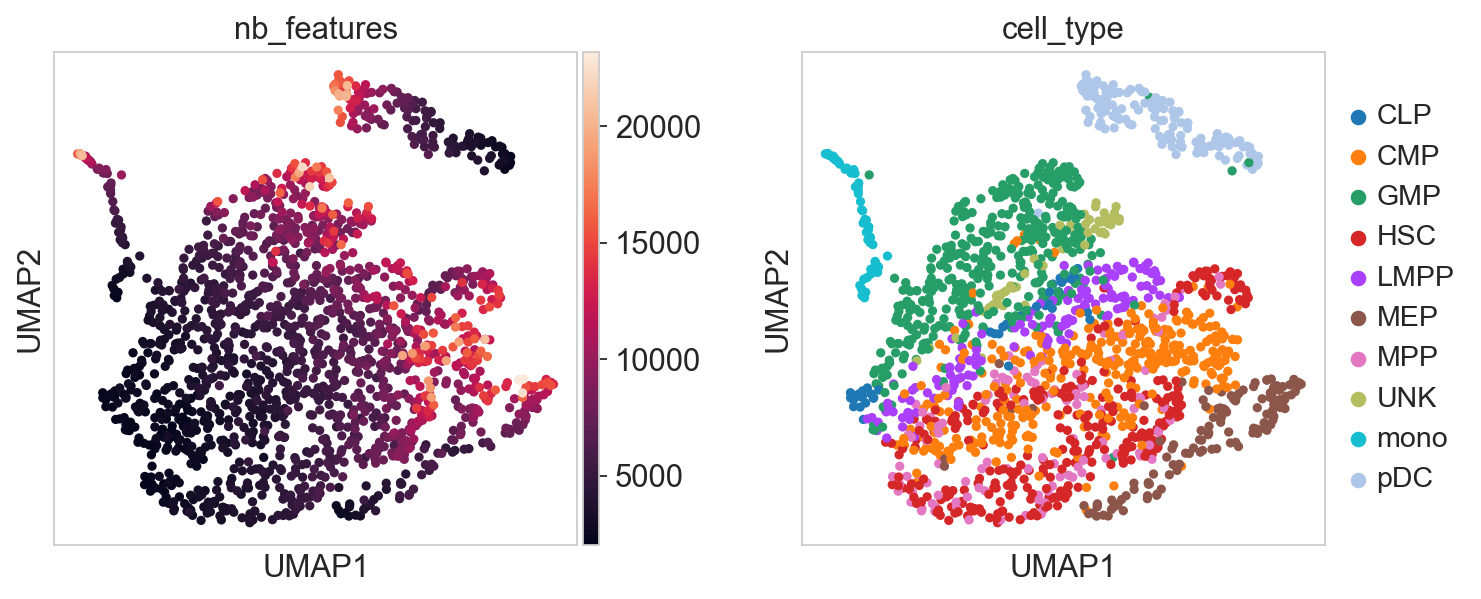

In [111]:
epi.pp.lazy(adata,pp_pca=False,nb_pcs=100)
sc.pl.umap(adata, color=['nb_features', 'cell_type'], wspace=0.3)